In [1]:
import pandapower.networks as pn

net = pn.create_cigre_network_lv()

In [2]:
net.switch.loc[1, "closed"] = False
net.switch.loc[2, "closed"] = False

In [3]:
# Iterate over all loads in the network and set controllable to False
for load_idx in net.load.index:
    net.load.at[load_idx, 'controllable'] = False

In [4]:
# Set line loading limits for all lines
for line_idx in net.line.index:
    net.line.at[line_idx, 'max_loading_percent'] = 100  # Set the maximum loading limit to 100%

In [5]:
import numpy as np
import pandas as pd

import pandapower as pp
import pandapower.control as control
import pandapower.networks as nw
import pandapower.timeseries as timeseries
from pandapower.timeseries import OutputWriter, DFData
from pandapower.control import ConstControl

In [6]:
# Load and preprocess the PV generation profile CSV file
df_pv = pd.read_csv("pv_generation_profile.csv")
df_pv['time'] = pd.to_datetime(df_pv['time'], format='%H:%M:%S').dt.time
df_pv['time_step'] = range(len(df_pv))  # Create a numerical index
df_pv.set_index('time_step', inplace=True)
df_pv['pvgen'] = df_pv['pvgen'] * 2500 / 1000
ds_pv = DFData(df_pv)

In [7]:
# Load and preprocess the load profile CSV file
df = pd.read_csv("load_profile_1111.csv")
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
df['time_step'] = range(len(df))  # Create a numerical index
df.set_index('time_step', inplace=True)
df['mult'] = df['mult'] * 150 / 1000
ds = DFData(df)

In [8]:
# Set constant loads to 3 kW for all loads except R11 to R18
constant_loads = net.load.index.difference([1, 2, 3, 4, 5])  # Indices of loads R1, I2, C1, C12, C13, C14, C17, C18, C19, C20
net.load.loc[constant_loads, 'p_mw'] = 15/1000

In [9]:
profile_loads = net.load.index.intersection([0, 1, 2, 3, 4, 5])
const_load = ConstControl(net, element='load', element_index=profile_loads,
                          variable='p_mw', data_source=ds, profile_name=["mult"] * len(profile_loads))

In [10]:
# Add PV generators to the corresponding buses
pv_buses = [12, 16, 17, 18, 19]
pv_generators = []
for bus in pv_buses:
    pv_gen = pp.create_sgen(net, bus, p_mw=0, q_mvar=0, type='pv', controllable=True)
    # Set initial limits
    net.sgen.at[pv_gen, 'min_p_mw'] = 0
    net.sgen.at[pv_gen, 'max_p_mw'] = df_pv['pvgen'].max()  # Set this to the maximum possible value in the profile
    pv_generators.append(pv_gen)

In [11]:
# Define cost functions for PV generators and generators to allow curtailment
# Update polynomial and piecewise linear costs
for pv_gen in pv_generators:
    pp.create_poly_cost(net, pv_gen, 'sgen', cp1_eur_per_mw=-1)
    pp.create_poly_cost(net, pv_gen, 'gen', cp1_eur_per_mw=-1)
    #pp.create_pwl_cost(net, pv_gen, "sgen", [[net.sgen.min_p_mw.at[0], net.sgen.max_p_mw.at[0], -1]])
    #pp.create_pwl_cost(net, pv_gen, "gen", [[net.gen.min_p_mw.at[0], net.gen.max_p_mw.at[0], -1]])

# Initialize ConstControl for PV and load profiles with correct time steps
const_pv = ConstControl(net, element='sgen', element_index=pv_generators,
                        variable='p_mw', data_source=ds_pv, profile_name=["pvgen"] * len(pv_generators))

In [12]:
# Define the OPF function
def run_opf(net):
    try:
        pp.rundcopp(net, delta=1e-16, verbose=False)
        # Print OPF results for debugging
        print("OPF Results:")
        print(net.res_load)
        print(net.res_sgen)
        cost = net.res_cost  # Extract the cost from the OPF results
        return True, True, cost  # OPF and control converged
    except pp.optimal_powerflow.OPFNotConverged:
        print("OPF did not converge. Please check the network configuration and constraints.")
        return False, False, None  # OPF and control did not converge

In [13]:
# Create data storage for manual logging
results = {
    "time_step": [],
    "line_loading_percent": [],
    "load_p_mw": [],
    "sgen_p_mw": [],
    "cost": []
}

In [14]:
# Manually run the time series simulation
time_steps = df_pv.index  # Use the actual time step index from df_pv
for t in time_steps:
    current_time = df_pv.loc[t, 'time'].strftime('%H:%M:%S')  # Convert the time to a string
    
    # Update the PV generation limits for each time step
    for i, pv_gen in enumerate(pv_generators):
        max_p = df_pv.loc[t, 'pvgen']
        net.sgen.at[pv_gen, 'max_p_mw'] = max_p
    
    # Update the control objects to the current time step
    const_pv.time_step(net, time=t)  # Use the time step index `t`
    const_load.time_step(net, time=t)  # Use the time step index `t`

    # Print the updated load values to verify
    print(f"Time step: {t}")
    print("Updated load values (p_mw):")
    print(net.load.p_mw)
    print("Updated PV generation values (p_mw):")
    print(net.sgen.p_mw)
    
    # Run OPF and get convergence status
    pf_converged, ctrl_converged, cost = run_opf(net)

    # Log results for the current time step
    results["time_step"].append(t)
    results["line_loading_percent"].append(net.res_line.loading_percent.values)
    results["load_p_mw"].append(net.res_load.p_mw.values)
    results["sgen_p_mw"].append(net.res_sgen.p_mw.values)
    results["cost"].append(cost)
    

# Convert results to DataFrame and save to Excel
results_df = pd.DataFrame({
    "time_step": results["time_step"],
    "line_loading_percent": [list(loading_percent) for loading_percent in results["line_loading_percent"]],
    "load_p_mw": [list(load_p_mw) for load_p_mw in results["load_p_mw"]],
    "sgen_p_mw": [list(sgen_p_mw) for sgen_p_mw in results["sgen_p_mw"]],
    "cost": results["cost"]
})
results_df.to_excel("output_results_dc.xlsx", index=False)

Time step: 0
Updated load values (p_mw):
0     0.045
1     0.045
2     0.045
3     0.045
4     0.045
5     0.045
6     0.015
7     0.015
8     0.015
9     0.015
10    0.015
11    0.015
12    0.015
13    0.015
14    0.015
Name: p_mw, dtype: object
Updated PV generation values (p_mw):
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: p_mw, dtype: object
OPF Results:
     p_mw  q_mvar
0   0.045     NaN
1   0.045     NaN
2   0.045     NaN
3   0.045     NaN
4   0.045     NaN
5   0.045     NaN
6   0.000     NaN
7   0.000     NaN
8   0.000     NaN
9   0.000     NaN
10  0.000     NaN
11  0.000     NaN
12  0.000     NaN
13  0.000     NaN
14  0.000     NaN
           p_mw  q_mvar
0  1.000000e-16     NaN
1  1.000000e-16     NaN
2  1.000000e-16     NaN
3  1.000000e-16     NaN
4  1.000000e-16     NaN
Time step: 1
Updated load values (p_mw):
0     0.044121
1     0.044121
2     0.044121
3     0.044121
4     0.044121
5     0.044121
6        0.015
7        0.015
8        0.015
9        0.015
10       

In [15]:
time_steps

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95],
           dtype='int64', name='time_step')

In [16]:
import ast

# Check and convert string representations of lists back to actual lists if necessary
def convert_to_list_if_needed(cell):
    if isinstance(cell, str):
        return eval(cell)
    return cell

results_df['line_loading_percent'] = results_df['line_loading_percent'].apply(convert_to_list_if_needed)
results_df['load_p_mw'] = results_df['load_p_mw'].apply(convert_to_list_if_needed)
results_df['sgen_p_mw'] = results_df['sgen_p_mw'].apply(convert_to_list_if_needed)
results_df['cost'] = results_df['cost'].apply(convert_to_list_if_needed)

In [17]:
# Create individual DataFrames for each result type
loading_percent = pd.DataFrame(results_df['line_loading_percent'].tolist(), index=results_df['time_step'])
load_p_mw = pd.DataFrame(results_df['load_p_mw'].tolist(), index=results_df['time_step'])
sgen_p_mw = pd.DataFrame(results_df['sgen_p_mw'].tolist(), index=results_df['time_step'])
cost = pd.DataFrame(results_df['cost'].tolist(), index=results_df['time_step'])


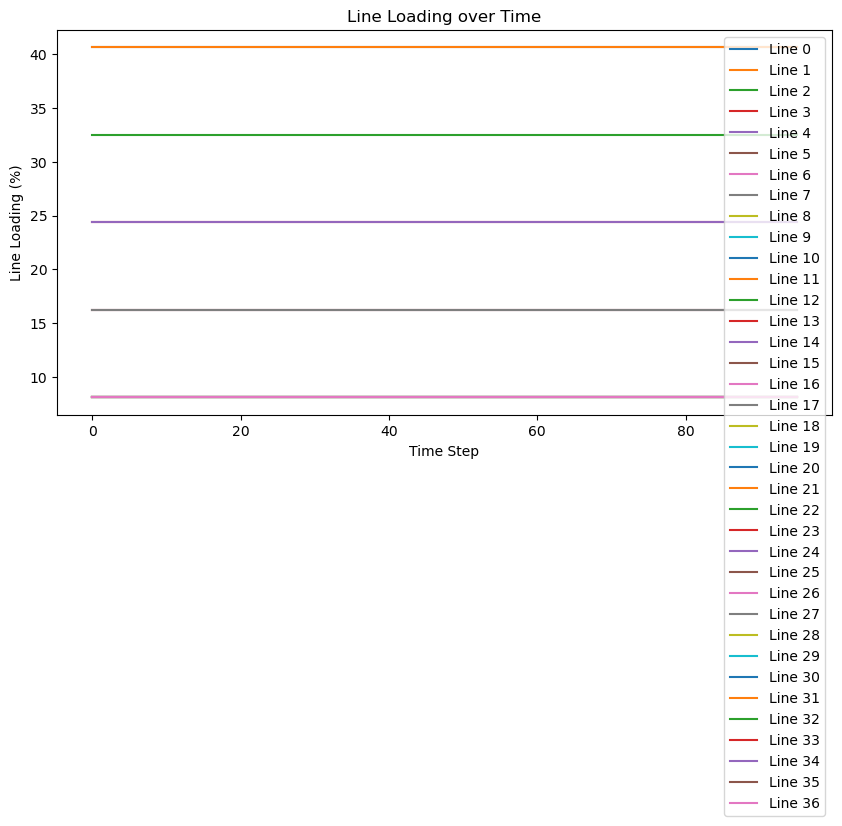

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for column in loading_percent.columns:
    plt.plot(loading_percent.index, loading_percent[column], label=f'Line {column}')
plt.xlabel('Time Step')
plt.ylabel('Line Loading (%)')
plt.title('Line Loading over Time')
plt.legend()
plt.show()

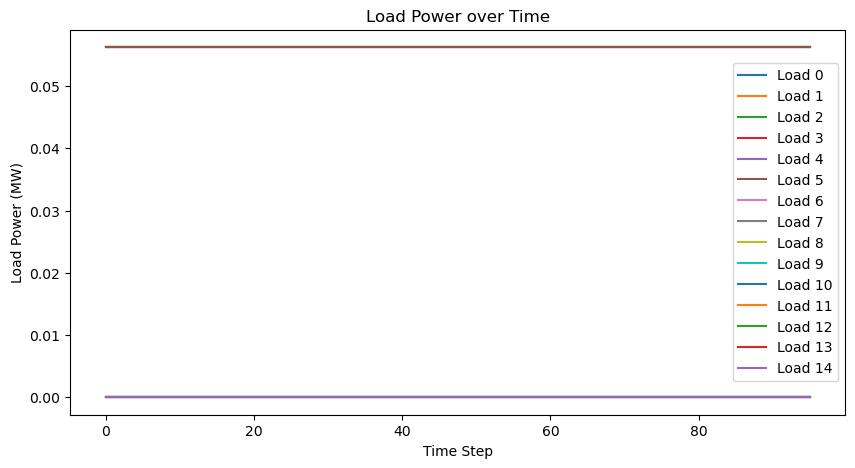

In [19]:
plt.figure(figsize=(10, 5))
for column in load_p_mw.columns:
    plt.plot(load_p_mw.index, load_p_mw[column], label=f'Load {column}')
plt.xlabel('Time Step')
plt.ylabel('Load Power (MW)')
plt.title('Load Power over Time')
plt.legend()
plt.show()

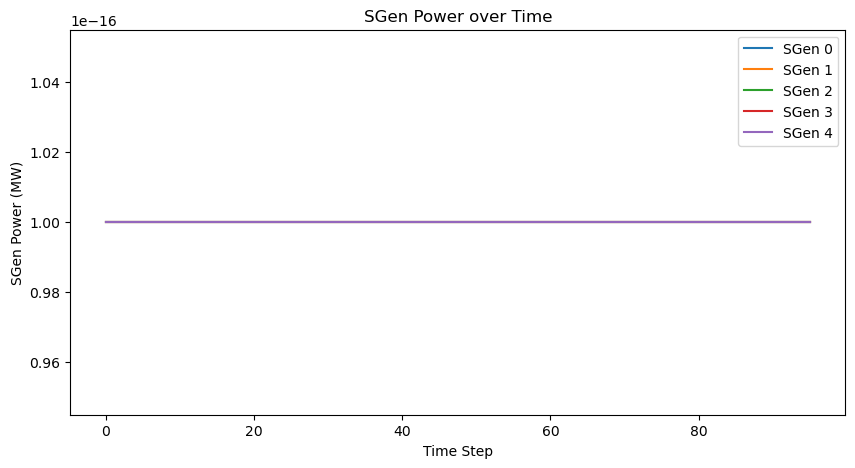

In [20]:
plt.figure(figsize=(10, 5))
for column in sgen_p_mw.columns:
    plt.plot(sgen_p_mw.index, sgen_p_mw[column], label=f'SGen {column}')
plt.xlabel('Time Step')
plt.ylabel('SGen Power (MW)')
plt.title('SGen Power over Time')
plt.legend()
plt.show()

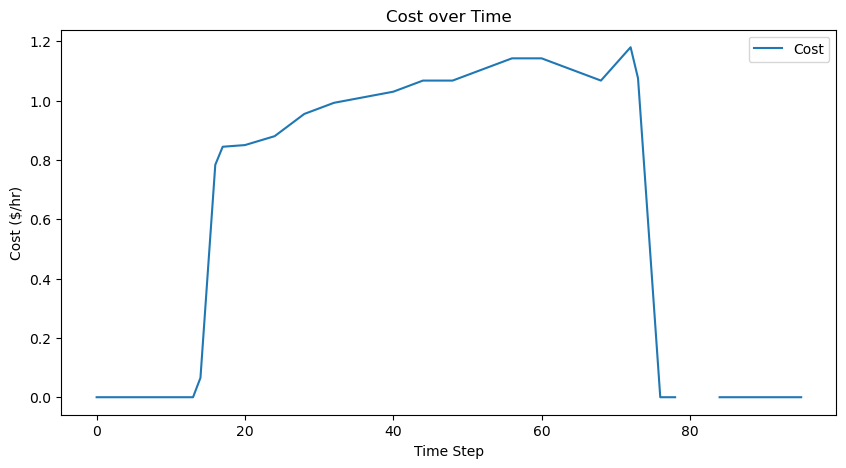

In [21]:
# Plot the cost over time
plt.figure(figsize=(10, 5))
plt.plot(results_df['time_step'], results_df['cost']*-1, label='Cost')
plt.xlabel('Time Step')
plt.ylabel('Cost ($/hr)')
plt.title('Cost over Time')
plt.legend()
plt.show()

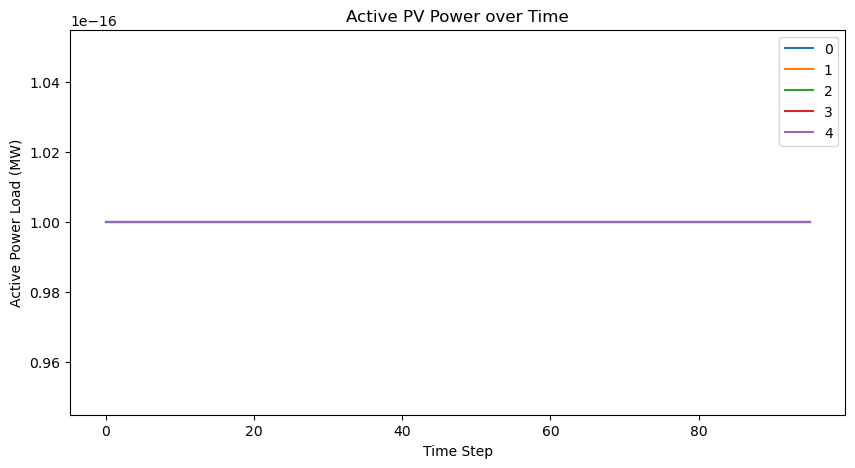

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(sgen_p_mw, label=sgen_p_mw.columns)
plt.xlabel('Time Step')
plt.ylabel('Active Power Load (MW)')
plt.title('Active PV Power over Time')
plt.legend()
plt.show()

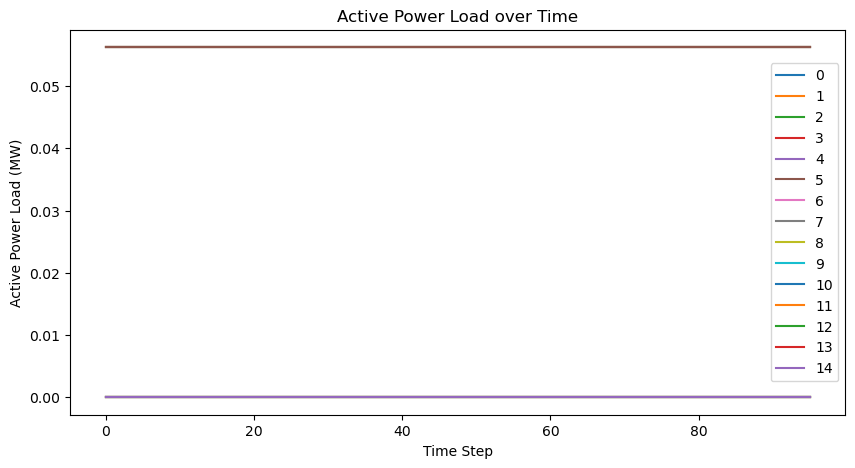

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(load_p_mw, label=load_p_mw.columns)
plt.xlabel('Time Step')
plt.ylabel('Active Power Load (MW)')
plt.title('Active Power Load over Time')
plt.legend()
plt.show()

               time  pvgen
time_step                 
0          00:00:00    0.0
1          00:15:00    0.0
2          00:30:00    0.0
3          00:45:00    0.0
4          01:00:00    0.0


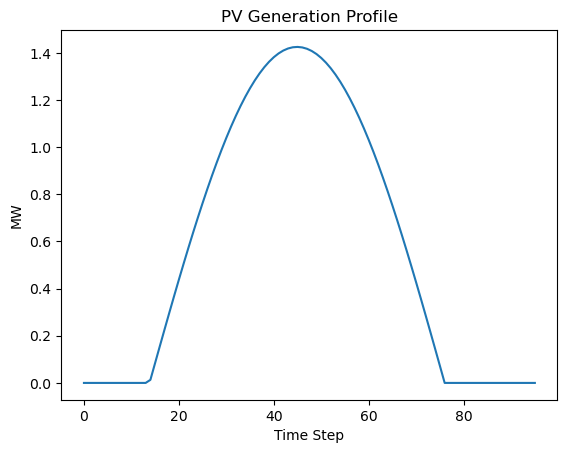

In [24]:
import matplotlib.pyplot as plt

# Print the first few rows of the PV generation profile
print(df_pv.head())

# Plot the PV generation profile
plt.plot(df_pv['pvgen'])
plt.title('PV Generation Profile')
plt.xlabel('Time Step')
plt.ylabel('MW')
plt.show()